- 姓名：林芷翎
- 學號：711133123
- 作品目標：本研究以Yale Faces資料集為探討對象，使用三種不同的分類器對原始資料及經主成分分析後的資料進行分類。研究中針對不同的參數設計進行探討，並進一步探討參數如何影響分類結果，以及如何縮短分析時間。由於Yale Faces資料集具有相對多的變數，因此如何選擇參數對於提高分類準確率和效率十分重要。

In [28]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

讀取與切割資料
- Yale Faces資料集，包含38人2410張人臉圖像
- X 的維度為 2410（2410張圖像）X 32256（圖像大小192*168），是所有人臉資料的數字矩陣，其值代表每張圖像的灰度值
- y 代表 2410張圖像分別屬於哪一個人物
- 將資料的70%切分為訓練資料，30%切分為測試集資料

In [16]:
D = scipy.io.loadmat('data/allFaces.mat')
X = D['faces'].T
y_n = np.ndarray.flatten(D['nfaces'])
y = [i+1 for i, val in enumerate(y_n) for _ in range(val)]
m = int(D['m'])
n = int(D['n'])
n_persons = int(D['person']) #38人

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

呈現出38位的第一張人臉影像

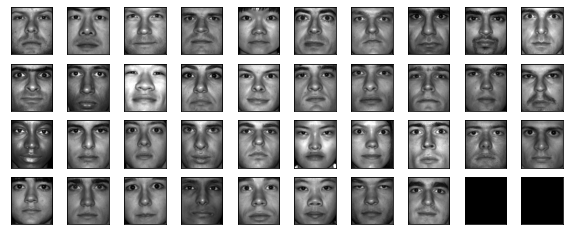

In [17]:
def show_montage(X, n, m, h, w): 
    '''
    X: 影像資料矩陣，每行代表一張影像
    n,m: 每張影像的大小 nxm
    h,w: 建立一個蒙太奇圖陣，大小 figsize=(w,h)
    '''
    fig, axes = plt.subplots(h, w, figsize=(w, h)) 
    if X.shape[1] < w*h:# 影像張數不到 wxh 張，用 0 向量補齊
        X = np.c_[X, np.zeros((X.shape[0], w*h-X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n).T, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

all_diff_persons = np.zeros((m*n, n_persons))
cnt = 0
for i in range(n_persons):
    all_diff_persons[:,i] = X.T[:,cnt]
    cnt = cnt + y_n[i]
show_montage(all_diff_persons, n, m, 4,10)


#### 一、多元羅吉斯迴歸（Multiple logistic regression analysis）

1. 將原始資料使用優化器（liblinear）透過羅吉斯迴歸進行分類任務  
&rarr; 原始資料的準確率為92%，訓練時間約20分鐘，為了節省訓練時間，接著採取主成分分析，選取合適的主成分個數以利後續分析。

In [18]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose = 0) 
solver = 'liblinear' 
clf_original = LogisticRegression(solver = solver, **opts)
clf_original.fit(X_train, y_train)
y_pred = clf_original.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.91      1.00      0.95        20
           2       0.83      1.00      0.91        20
           3       0.94      0.94      0.94        16
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        17
           6       0.78      0.82      0.80        17
           7       0.85      1.00      0.92        17
           8       0.95      1.00      0.98        20
           9       0.90      1.00      0.95        18
          10       0.89      1.00      0.94        24
          11       1.00      0.93      0.96        14
          12       1.00      1.00      1.00        14
          13       1.00      0.85      0.92        20
          14       0.95      0.95      0.95        22
          15       0.95      0.95      0.95        19
          16       0.59      0.81      0.68        16
          17       1.00      0.95      0.98        21
          18       1.00    

2. 將資料標準化後進行主成分分析，並且畫出PCA的解釋變異數比例累加圖：
- x軸是主成分的數量，y軸是解釋變異數的累加比例
- 主成份個數為61，可以解釋95%的變異量

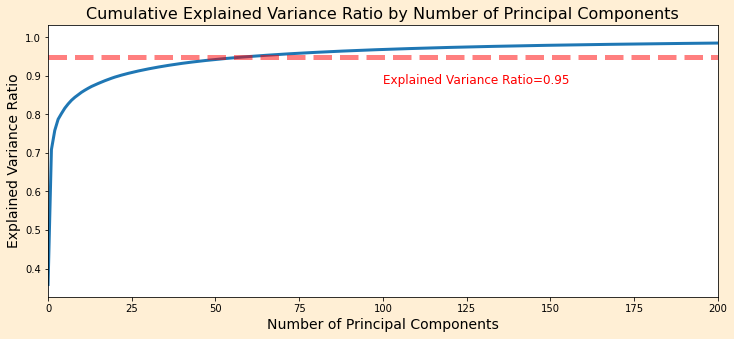

Number of Principal Components needed to explain 95% variance: 61


In [19]:
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

pca = PCA().fit(X_train)
plt.figure(figsize=(12, 5)).set_facecolor("papayawhip")
plt.plot(pca.explained_variance_ratio_.cumsum(), lw = 3)
plt.axhline(y = 0.95, color = 'red', alpha = 0.5, ls = '--', lw = 5)
plt.xlabel('Number of Principal Components', fontsize = 14)
plt.ylabel('Explained Variance Ratio', fontsize = 14)
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components', fontsize = 16)
plt.text(100, 0.88, "Explained Variance Ratio=0.95", fontsize=12, color='red')
plt.xlim(0,200)
plt.show()

var_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(var_ratio_cumsum >= 0.95) + 1
print(f"Number of Principal Components needed to explain 95% variance: {n_components}")


3. 將主成分分析後的資料，選取不同的學習器並使用 LogisticRegression 進行分類任務，觀察結果。 
- 主成分選取：60個主成分 
- 三個學習器：『L-BFGS』、『LIBLINEAR』與『Newton-CG』

&rarr; 主成分分析後的準確率（Accuracy）皆高於90％。學習器選擇『L-BFGS』與『LIBLINEAR』訓練時間（Times）皆不到一分鐘，明顯將資料進行主成分分析後，訓練更有效率。

<center>

| | L-BFGS | LIBLINEAR | Newton-CG |
| :--- | :---: | :---: |  :---: | 
| Accuracy | 92.53% | 89.90% | 92.95% | 
| Times | 30s | 9s | 21m5s | 

<center>

In [23]:
pca = PCA(n_components = 60).fit(X_train_)
Z_train = pca.transform(X_train_)
Z_test = pca.transform(X_test_)
solver = 'lbfgs'
clf_PCA = LogisticRegression(solver = solver, **opts)
print(f"Accuracy : {clf_PCA.fit(Z_train, y_train).score(Z_test, y_test):.2%}\n")

Accuracy : 92.53%



#### 二、支援向量機（Support Vector Machine）

1. 原始資料設定下列參數使用支援向量機（SVM）進行分類任務
- 正規劃參數：c = 1
- 分類方式：one vs one (ovo)
- 核函數：線性核函數（linear）  

&rarr; 對於原始資料，使用正規化參數c = 1和線性核函數（linear）進行分類，取得92%的分類準確率。

In [24]:
C = 1 
opts = dict(C = C, decision_function_shape = "ovo",tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel = "linear", gamma = 0.2, **opts)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.91      1.00      0.95        20
           2       0.73      0.95      0.83        20
           3       0.93      0.88      0.90        16
           4       0.95      1.00      0.97        19
           5       0.85      1.00      0.92        17
           6       0.94      0.94      0.94        17
           7       0.77      1.00      0.87        17
           8       0.90      0.90      0.90        20
           9       0.93      0.78      0.85        18
          10       0.78      0.88      0.82        24
          11       0.93      0.93      0.93        14
          12       1.00      1.00      1.00        14
          13       1.00      0.90      0.95        20
          14       1.00      1.00      1.00        22
          15       0.95      1.00      0.97        19
          16       0.83      0.94      0.88        16
          17       1.00      1.00      1.00        21
          18       1.00    

2. 將資料進行主成分分析，並且使用 SVC 進行分類任務   

In [25]:
pca = PCA(n_components = 100).fit(X_train_)
Z_train = pca.transform(X_train_)
Z_test = pca.transform(X_test_)
opts = dict(C = C,tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel="linear", gamma = 0.2, **opts) 
print(f"SVM : {clf_svm.fit(Z_train, y_train).score(Z_test, y_test):.2%}\n")

SVM : 90.59%



3. 不同的主成分個數（10至200）與核函數的分類準確率
- 線性 ( kernel = 'linear' )
- 多項式 ( kernel = 'poly' )
- 高斯基函數 ( kernel = 'rbf' ) 

/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


       PCA(q=10) PCA(q=20) PCA(q=40) PCA(q=60) PCA(q=100) PCA(q=200)
linear    63.21%    83.54%    87.00%    89.21%     90.32%     91.42%
poly      57.95%    75.93%    80.08%    82.57%     82.30%     83.26%
rbf        1.80%     1.80%     1.80%     1.80%      1.80%      1.80%


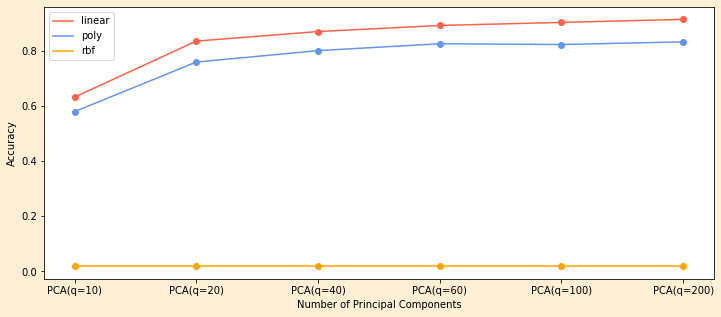

In [26]:
q = [10,20,40,60,100,200]
kernel = ['linear', 'poly', 'rbf'] 
opts = dict(C = C,tol = 1e-6, max_iter = int(1e6))
 
results = {}
for n in q:
    pca = PCA(n_components = n).fit(X_train_)
    Z_train = pca.transform(X_train_)
    Z_test = pca.transform(X_test_)
    solver_results = {}
    for x in kernel:
        clf_svm = SVC(kernel=x, gamma = 0.2, **opts)
        accuracy = clf_svm.fit(Z_train, y_train).score(Z_test, y_test)
        solver_results[x] = accuracy
    results[f"PCA(q={n})"] = solver_results

df = pd.DataFrame(results)
print(df.applymap(lambda x: '{:.2%}'.format(x)))

# 折線圖
plt.figure(figsize=(12, 5)).set_facecolor("papayawhip")
x = df.columns.values
colors = ['tomato', 'cornflowerblue', 'orange']

for i, solver in enumerate(df.index):
    accuracy = df.loc[solver].values
    plt.plot(x, accuracy, color=colors[i], label=solver)
    plt.scatter(x, accuracy, color=colors[i])
plt.gca().set_facecolor('white')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    比較結果
- 『linear』核函數在分類準確率上表現最佳，主成分個數為40以上的準確率都高於80%，上升的幅度不明顯。
- 當主成分選取數量增加時，使用『poly』核函數對分類準確率的提升效果並不明顯。
- 使用『rbf』核函數時，所有主成分個數下的分類準確率皆為 1.8%。這是因為RBF核函數在標準化後的資料上表現不佳，高估了線性分類器的性能。

#### 三、神經網路（Neural network）
1. 使用MLPClassifier建立一個多層感知機模型，使用原始資料訓練模型
- 隱藏層的神經元數量（hidden_layers）：一層30個神經元
- 學習器（solver）：adam
- 激活函數（activation）: logistic
- 準確率（accuracy）：93%
- 損失函數（Loss Curve）：損失值很高，且與迭代次數呈現的下降情形不穩定

&rarr; 在資料進行標準化前，所有類別的分類準確率幾乎都接近0%，這表示模型無法對資料進行有效的分類。使用標準化後的資料進行訓練，分類結果大幅改善，模型的準確率高達93%。

              precision    recall  f1-score   support

           1       1.00      0.95      0.97        20
           2       0.70      0.95      0.81        20
           3       1.00      0.94      0.97        16
           4       0.95      1.00      0.97        19
           5       0.89      1.00      0.94        17
           6       0.94      0.94      0.94        17
           7       0.94      1.00      0.97        17
           8       1.00      0.90      0.95        20
           9       1.00      0.94      0.97        18
          10       0.96      0.96      0.96        24
          11       1.00      0.93      0.96        14
          12       1.00      1.00      1.00        14
          13       1.00      0.90      0.95        20
          14       1.00      1.00      1.00        22
          15       0.95      1.00      0.97        19
          16       0.83      0.94      0.88        16
          17       1.00      1.00      1.00        21
          18       1.00    

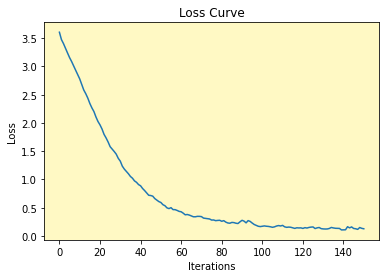

In [27]:
hidden_layers = (30,)
activation = 'logistic'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, activation = activation, tol = 1e-6, max_iter = int(1e6))

solver = 'adam'
clf_MLP = MLPClassifier(solver = solver, **opts) 
clf_MLP.fit(X_train_, y_train)
predictions = clf_MLP.predict(X_test_)

print(classification_report(y_test, predictions))
plt.gca().set_facecolor('#FFF9C4')
plt.plot(clf_MLP.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


2. 進行主成分分析（PCA）降維，並使用MLPClassifier進行分類任務  
&rarr; 將資料進行主成分分析，選取主成分個數後進行分類任務，時間上節省了許多。  
&rarr; 主成份個數選取60個

In [29]:
pca = PCA(n_components = 60).fit(X_train_)
Z_train = pca.transform(X_train_)
Z_test = pca.transform(X_test_)

3. 分別比較不同的神經元個數、激活函數與學習器使用MLPClassifier的分類準確率
- 神經元個數(hidden_layers_list) ：30、 50
- 激活函數（activation）： 『identity』、『logistic』、『relu』、『tanh』
- 學習器（solver）：『adam』、『adam』、『lbfgs』

In [30]:
from sklearn.neural_network import MLPClassifier

hidden_layers_list = [(30,), (50,)]
activation_list = ['identity', 'logistic', 'relu', 'tanh']
solver_list = ['adam', 'sgd', 'lbfgs']

accuracy_list = []
for hidden_layers in hidden_layers_list:
    for activation in activation_list:
        for solver in solver_list:
            print(f'Training model with hidden_layers={hidden_layers}, activation={activation}, solver={solver}')
            opts = dict(hidden_layer_sizes=hidden_layers, verbose=False,
                        activation=activation, tol=1e-6, max_iter=int(1e6))
            clf_MLP = MLPClassifier(solver=solver, **opts)
            clf_MLP.fit(Z_train, y_train)
            y_pred = clf_MLP.predict(Z_test)
            accuracy = clf_MLP.score(Z_test, y_test)
            accuracy_list.append({'hidden_layers': hidden_layers, 'activation': activation, 'solver': solver, 'accuracy': accuracy})


Training model with hidden_layers=(30,), activation=identity, solver=adam
Training model with hidden_layers=(30,), activation=identity, solver=sgd
Training model with hidden_layers=(30,), activation=identity, solver=lbfgs
Training model with hidden_layers=(30,), activation=logistic, solver=adam
Training model with hidden_layers=(30,), activation=logistic, solver=sgd
Training model with hidden_layers=(30,), activation=logistic, solver=lbfgs


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training model with hidden_layers=(30,), activation=relu, solver=adam
Training model with hidden_layers=(30,), activation=relu, solver=sgd
Training model with hidden_layers=(30,), activation=relu, solver=lbfgs
Training model with hidden_layers=(30,), activation=tanh, solver=adam
Training model with hidden_layers=(30,), activation=tanh, solver=sgd
Training model with hidden_layers=(30,), activation=tanh, solver=lbfgs
Training model with hidden_layers=(50,), activation=identity, solver=adam
Training model with hidden_layers=(50,), activation=identity, solver=sgd
Training model with hidden_layers=(50,), activation=identity, solver=lbfgs
Training model with hidden_layers=(50,), activation=logistic, solver=adam
Training model with hidden_layers=(50,), activation=logistic, solver=sgd
Training model with hidden_layers=(50,), activation=logistic, solver=lbfgs
Training model with hidden_layers=(50,), activation=relu, solver=adam
Training model with hidden_layers=(50,), activation=relu, solver=s

繪圖呈現分類結果

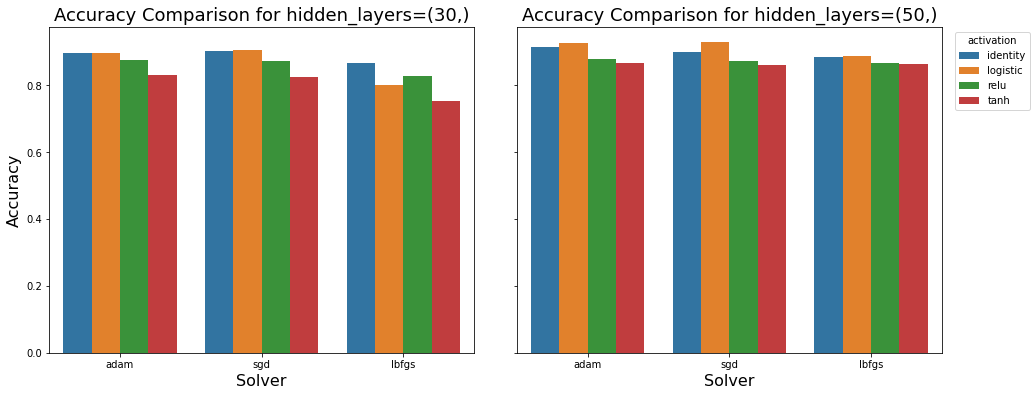

In [38]:
accuracy_df = pd.DataFrame(accuracy_list)
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# hidden_layers=(30,)
sns.barplot(x='solver', y='accuracy', hue='activation', data=accuracy_df[accuracy_df['hidden_layers'] == (30,)], dodge=True, ax=axs[0])
axs[0].set_title('Accuracy Comparison for hidden_layers=(30,)', fontsize=18)
axs[0].set_xlabel('Solver', fontsize=16)
axs[0].set_ylabel('Accuracy', fontsize=16)
axs[0].legend().set_visible(False)

# hidden_layers=(50,)
sns.barplot(x='solver', y='accuracy', hue='activation', data=accuracy_df[accuracy_df['hidden_layers'] == (50,)], dodge=True, ax=axs[1])
axs[1].set_title('Accuracy Comparison for hidden_layers=(50,)', fontsize=18)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[1].set_xlabel('Solver', fontsize=16)
axs[1].set_ylabel('')
axs[1].legend(title = 'activation', bbox_to_anchor=(1.02, 1))
plt.subplots_adjust(wspace=0.1)
plt.show()


混淆矩陣（Confusion Matrix）

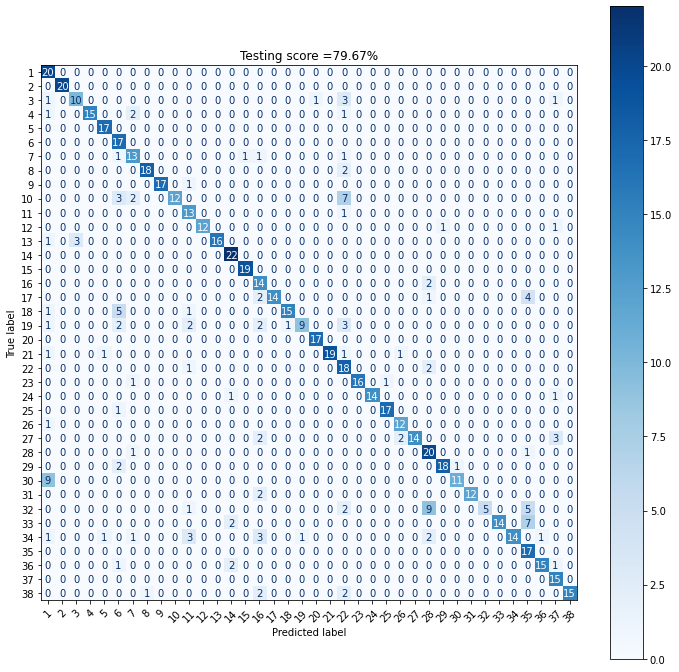

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
hidden_layers = (50,)
activation = 'logistic'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, activation = activation, tol = 1e-6, max_iter = int(1e6))

solver = 'adam'
clf_MLP = MLPClassifier(solver = solver, **opts) 
clf_MLP.fit(X_train_, y_train)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
score = 100*clf_MLP.score(X_test, y_test)
title = 'Testing score ={:.2f}%'.format(score)
disp = ConfusionMatrixDisplay.from_estimator(
        clf_MLP,
        X_test,
        y_test,
        cmap = plt.cm.Blues,
        xticks_rotation = 45, #’vertical’, # display_labels=class_names, cmap=plt.cm.Blues, normalize=’true’,
        ax = ax
    )
disp.ax_.set_title(title)
plt.show()

&rarr; testing_scoring=79.67%，代表模型能夠準確預測測試集中大約79.67%的樣本。

    比較結果
- 本小節進行了24種不同的分析，分別考慮了2種神經元個數、4種激活函數與3種學習器。
- 分析結果中，當神經元個數為50、激活函數選擇『logistic』，並且學習器選擇『sgd』時，可以得到最高的準確率為92.8%。

In [43]:
idx = np.argpartition(accuracy_df['accuracy'], -3)[-3:]
accuracy_df.loc[idx]

,hidden_layers,activation,solver,accuracy
12,"(50,)",identity,adam,0.914246
15,"(50,)",logistic,adam,0.925311
16,"(50,)",logistic,sgd,0.928077


    結論：
- 在多元羅吉斯迴歸中，原始資料的準確率為93%，訓練時間約38分鐘，為了節省訓練時間，接著採取主成分分析，選取主成分個數為60，使用『newton-cg』學習器，能夠獲得最高的分類準確率94.05%。  
- 在支援向量機中，對於原始資料，使用正規化參數c = 1和線性核函數（linear）進行分類，取得了92%的分類準確率。採取主成分分析後，主成分個數為80，核函數為『linear』，能夠獲得不錯的分類準確率90.18%。
- 在神經網路中，當神經元個數為50、激活函數選擇『logistic』，並且學習器選擇『sgd』時，可以得到最高的準確率為92.8%。  

&rarr; 總體而言，針對這個資料集，使用多元羅吉斯迴歸得到的分類準確率最好，同時也花費了最少的訓練時間。然而，由於樣本抽樣的影響，這個結果只能呈現相對的準確率比較，想進一步比較不同演算法之間的差異，可以使用重複抽樣再取平均值的方式來探討分類結果。